In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the amino acid alphabet
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
AA_TO_IDX = {aa: idx for idx, aa in enumerate(AMINO_ACIDS)}
IDX_TO_AA = {idx: aa for idx, aa in enumerate(AMINO_ACIDS)}

class ProteinDataset(Dataset):
    """
    Custom dataset class for protein sequences and their properties.
    
    This class handles the conversion from amino acid sequences to numerical
    representations and manages the relationship between sequences and their
    target properties.
    """
    
    def __init__(self, sequences, targets, max_length=500):
        # If sequences/targets are pandas Series – drop old index and convert
        if isinstance(sequences, pd.Series):
            sequences = sequences.reset_index(drop=True).tolist()
        if isinstance(targets, pd.Series):
            targets = targets.reset_index(drop=True).tolist()

        self.sequences = sequences          # now a simple Python list
        self.targets   = targets            # plain list as well
        self.max_length = max_length

        # Normalise targets
        self.target_scaler = StandardScaler()
        self.normalized_targets = self.target_scaler.fit_transform(
            np.array(self.targets).reshape(-1, 1)
        ).flatten()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        target   = self.normalized_targets[idx]

        sequence_tensor = self.sequence_to_tensor(sequence)
        target_tensor   = torch.tensor(target, dtype=torch.float32)
        return sequence_tensor, target_tensor
    
    def sequence_to_tensor(self, sequence):
        """
        Convert a protein sequence string to a one-hot encoded tensor.
        
        This function handles padding and truncation to ensure all sequences
        have the same length.
        """
        # Truncate if too long
        if len(sequence) > self.max_length:
            sequence = sequence[:self.max_length]
        
        # Create one-hot encoding
        tensor = torch.zeros(self.max_length, len(AMINO_ACIDS))
        
        for i, aa in enumerate(sequence):
            if aa in AA_TO_IDX:
                tensor[i, AA_TO_IDX[aa]] = 1.0
        
        return tensor
    
    def denormalize_target(self, normalized_value):
        """
        Convert normalized target back to original scale.
        
        This is useful for interpreting model predictions.
        """
        return self.target_scaler.inverse_transform([[normalized_value]])[0][0]

In [ ]:
class ProteinCNN(nn.Module):
    """
    Convolutional Neural Network for protein sequence analysis.
    
    This network uses multiple convolutional layers with different filter sizes
    to capture local patterns in protein sequences, followed by fully connected
    layers to make the final prediction.
    """
    
    def __init__(self, num_amino_acids=20, num_filters=128, dropout_rate=0.5):
        """
        Initialize the CNN architecture.
        
        Args:
            num_amino_acids: Size of amino acid vocabulary (20 for standard amino acids)
            num_filters: Number of convolutional filters for each filter size
            dropout_rate: Dropout probability for regularization
        """
        super(ProteinCNN, self).__init__()
        
        # Multiple convolutional layers with different filter sizes
        # This allows us to capture patterns of different lengths
        self.conv1 = nn.Conv1d(num_amino_acids, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(num_amino_acids, num_filters, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(num_amino_acids, num_filters, kernel_size=7, padding=3)
        
        # Batch normalization helps with training stability
        self.batch_norm1 = nn.BatchNorm1d(num_filters)
        self.batch_norm2 = nn.BatchNorm1d(num_filters)
        self.batch_norm3 = nn.BatchNorm1d(num_filters)
        
        # Additional convolutional layers for more complex pattern detection
        self.conv4 = nn.Conv1d(num_filters * 3, num_filters * 2, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm1d(num_filters * 2)
        
        self.conv5 = nn.Conv1d(num_filters * 2, num_filters, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm1d(num_filters)
        
        # Global pooling to get a fixed-size representation
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(num_filters, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # Single output for regression
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape [batch_size, sequence_length, num_amino_acids]
            
        Returns:
            predictions: Tensor of shape [batch_size, 1] with predicted values
        """
        # Transpose for conv1d: [batch_size, num_amino_acids, sequence_length]
        x = x.transpose(1, 2)
        
        # Apply multiple convolutional layers with different filter sizes
        conv1_out = F.relu(self.batch_norm1(self.conv1(x)))
        conv2_out = F.relu(self.batch_norm2(self.conv2(x)))
        conv3_out = F.relu(self.batch_norm3(self.conv3(x)))
        
        # Concatenate outputs from different filter sizes
        # This gives us a rich representation that captures patterns of various lengths
        x = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)
        
        # Apply additional convolutional layers
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.dropout(x)
        
        x = F.relu(self.batch_norm5(self.conv5(x)))
        x = self.dropout(x)
        
        # Global pooling to get a fixed-size representation regardless of sequence length
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers for final prediction
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Final prediction (no activation for regression)
        x = self.fc3(x)
        
        return x

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from fpgen.prop_prediction.metrics import get_regression_metrics
import time

# Set random seeds for reproducibility
# This ensures that your results are consistent across runs
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

Training on: cuda


In [6]:
import tqdm


def train_cnn_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    """
    Train the CNN model with careful monitoring and early stopping.
    
    This function implements best practices for training neural networks on small datasets,
    including learning rate scheduling, early stopping, and comprehensive monitoring.
    """
    print(torch.cuda.device_count())
    torch.cuda.set_device(0)
    # Move model to the appropriate device (GPU if available)
    model = model.to(device)
    # print devices
    
    
    # Choose optimizer and loss function
    # Adam is generally a good choice for CNNs because it adapts the learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Mean Squared Error for regression tasks
    criterion = nn.MSELoss()
    
    # Learning rate scheduler - reduces learning rate when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=10, factor=0.5
    )
    
    # Early stopping to prevent overfitting
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 20
    
    # Track training history
    train_losses = []
    val_losses = []
    learning_rates = []
    
    print("Starting training...")
    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Validation batches per epoch: {len(val_loader)}")
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        # Training phase
        model.train()  # Set model to training mode
        train_loss = 0.0
        train_batches = 0
        for batch_idx, (sequences, targets) in enumerate(train_loader):
            # Move data to device
            sequences = sequences.to(device)
            targets = targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(sequences)
            
            # Calculate loss
            loss = criterion(predictions.squeeze(), targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update parameters
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        # Calculate average training loss
        avg_train_loss = train_loss / train_batches
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():  # Disable gradient computation for efficiency
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                predictions = model(sequences)
                loss = criterion(predictions.squeeze(), targets)
                
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        
        # Record history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')
        print('-' * 50)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_cnn_model.pth')
            print(f'New best model saved with validation loss: {best_val_loss:.6f}')
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    # Load the best model
    model.load_state_dict(torch.load('best_cnn_model.pth'))
    
    return model, train_losses, val_losses, learning_rates

In [7]:
def setup_data_loaders(fpbase_dataset, target_name='ex_max', batch_size=32, val_split=0.2):
    """
    Create training and validation data loaders using FPbase's train/test split.
    
    Args:
        fpbase_dataset: Instance of FPbase class
        target_name: Name of the target property (e.g., 'ex_max')
        batch_size: Batch size for DataLoader
        val_split: Fraction of training data to use for validation
    
    Returns:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        train_dataset: ProteinDataset instance for training data
    """
    
    # Get train and test data from FPbase
    x_train, y_train = fpbase_dataset.get_train(target_name, is_scaled=True)
    x_test, y_test = fpbase_dataset.get_test(target_name, is_scaled=True)
    
    # Create full training dataset
    train_full_dataset = ProteinDataset(x_train, y_train, max_length=500)
    
    # Split training data into train and validation
    total_size = len(train_full_dataset)
    train_size = int((1 - val_split) * total_size)
    val_size = total_size - train_size
    
    print(f"Full training set size: {total_size}")
    print(f"Training set size: {train_size}")
    print(f"Validation set size: {val_size}")
    print(f"Test set size: {len(x_test)}")
    
    # Split training dataset into train and validation
    train_dataset, val_dataset = random_split(
        train_full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    # Create test dataset
    test_dataset = ProteinDataset(x_test, y_test, max_length=500)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return train_loader, val_loader, test_loader, train_full_dataset

In [24]:
def evaluate_model(model, data_loader, dataset, fpbase_dataset, target_name='ex_max'):
    """
    Evaluate the trained model and calculate performance metrics.
    
    This function provides comprehensive evaluation including predictions
    on both normalized and original scales using FPbase rescaling.
    
    Args:
        model: The trained model
        data_loader: DataLoader with test/validation data
        dataset: ProteinDataset instance
        fpbase_dataset: FPbase instance for proper rescaling
        target_name: Name of the target property (default: 'ex_max')
    """
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            predictions = model(sequences)
            
            all_predictions.extend(predictions.squeeze().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate metrics on normalized scale
    metrics_normalized = get_regression_metrics(all_predictions, all_targets)
    
    # Rescale using FPbase for interpretable metrics
    targets_original = fpbase_dataset.rescale_targets(all_targets, target_name)
    predictions_original = fpbase_dataset.rescale_targets(all_predictions, target_name)
    
    # Calculate metrics on original scale
    metrics_original = get_regression_metrics(predictions_original, targets_original)
    
    print("\nModel Evaluation Results:")
    print(f"Normalized metrics:")
    print(f"  R² Score: {metrics_normalized['r2']:.4f}")
    print(f"  RMSE: {metrics_normalized['rmse']:.4f}")
    print(f"  MAE: {metrics_normalized['mae']:.4f}")
    print(f"  Median AE: {metrics_normalized['mae_median']:.4f}")
    
    print(f"\nOriginal scale metrics:")
    print(f"  R² Score: {metrics_original['r2']:.4f}")
    print(f"  RMSE: {metrics_original['rmse']:.4f}")
    print(f"  MAE: {metrics_original['mae']:.4f}")
    print(f"  Median AE: {metrics_original['mae_median']:.4f}")
    
    return {
        'predictions_original': predictions_original,
        'targets_original': targets_original,
        **{f"{k}_original": v for k, v in metrics_original.items()},
        **{f"{k}_normalized": v for k, v in metrics_normalized.items()}
    }

def plot_training_history(train_losses, val_losses, learning_rates):
    """
    Visualize the training process to understand model behavior.
    
    These plots help you understand whether your model is learning properly,
    overfitting, or if you need to adjust hyperparameters.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training and validation losses
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot learning rate schedule
    axes[0, 1].plot(learning_rates, color='green')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Learning Rate Schedule')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True)
    
    # Plot loss difference (overfitting indicator)
    loss_diff = np.array(val_losses) - np.array(train_losses)
    axes[1, 0].plot(loss_diff, color='purple')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Validation Loss - Training Loss')
    axes[1, 0].set_title('Overfitting Indicator')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].grid(True)
    
    # Plot validation loss with trend
    axes[1, 1].plot(val_losses, color='red', alpha=0.7)
    # Add trend line
    z = np.polyfit(range(len(val_losses)), val_losses, 1)
    p = np.poly1d(z)
    axes[1, 1].plot(range(len(val_losses)), p(range(len(val_losses))), 
                   color='black', linestyle='--', label='Trend')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Loss')
    axes[1, 1].set_title('Validation Loss with Trend')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [9]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [10]:
# Initialize FPbase dataset
from fpgen.prop_prediction.dataset import FPbase
dataset = FPbase()

# Create data loaders using FPbase's train/test split
batch_size = 32
train_loader, val_loader, test_loader, train_dataset = setup_data_loaders(
    fpbase_dataset=dataset,
    target_name='ex_max',
    batch_size=batch_size,
    val_split=0.2  # 20% of training data for validation
)

Full training set size: 676
Training set size: 540
Validation set size: 136
Test set size: 173


In [11]:
import torch
print("CUDA available :", torch.cuda.is_available())
print("GPU count       :", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i} name     :", torch.cuda.get_device_name(i))
    print(f"GPU {i} capability:",
          torch.cuda.get_device_capability(i))

CUDA available : True
GPU count       : 1
GPU 0 name     : NVIDIA GeForce RTX 4050 Laptop GPU
GPU 0 capability: (8, 9)


In [15]:
# Initialize model
model = ProteinCNN(
    num_amino_acids=20,  # Standard amino acids
    num_filters=128,
    dropout_rate=0.5
).to(device)

# Train model
print("Starting training...")
trained_model, train_losses, val_losses, learning_rates = train_cnn_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=200,
    learning_rate=0.001
)


Starting training...
1
Starting training...
Training batches per epoch: 17
Validation batches per epoch: 5


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Batch 0, Loss: 0.574682
Epoch 1, Batch 10, Loss: 0.860392


  0%|          | 1/200 [00:01<03:56,  1.19s/it]

Epoch 1/200:
  Train Loss: 1.024855
  Val Loss: 0.802737
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.802737
Epoch 2, Batch 0, Loss: 1.073037
Epoch 2, Batch 10, Loss: 0.958486


  1%|          | 2/200 [00:02<03:29,  1.06s/it]

Epoch 2/200:
  Train Loss: 0.835375
  Val Loss: 0.823267
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 3, Batch 0, Loss: 0.672881
Epoch 3, Batch 10, Loss: 0.620893


  2%|▏         | 3/200 [00:03<03:22,  1.03s/it]

Epoch 3/200:
  Train Loss: 0.705600
  Val Loss: 0.514284
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.514284
Epoch 4, Batch 0, Loss: 0.639360
Epoch 4, Batch 10, Loss: 0.366709


  2%|▏         | 4/200 [00:04<03:19,  1.02s/it]

Epoch 4/200:
  Train Loss: 0.625159
  Val Loss: 0.411808
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.411808
Epoch 5, Batch 0, Loss: 0.347700
Epoch 5, Batch 10, Loss: 0.699398


  2%|▎         | 5/200 [00:05<03:16,  1.01s/it]

Epoch 5/200:
  Train Loss: 0.525148
  Val Loss: 0.457347
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 6, Batch 0, Loss: 0.451325
Epoch 6, Batch 10, Loss: 0.576693


  3%|▎         | 6/200 [00:06<03:21,  1.04s/it]

Epoch 6/200:
  Train Loss: 0.502104
  Val Loss: 0.787681
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 7, Batch 0, Loss: 0.390205
Epoch 7, Batch 10, Loss: 0.360112


  4%|▎         | 7/200 [00:07<03:20,  1.04s/it]

Epoch 7/200:
  Train Loss: 0.488473
  Val Loss: 3.076435
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 8, Batch 0, Loss: 0.396196
Epoch 8, Batch 10, Loss: 0.561088


  4%|▍         | 8/200 [00:08<03:19,  1.04s/it]

Epoch 8/200:
  Train Loss: 0.487446
  Val Loss: 1.070230
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 9, Batch 0, Loss: 0.316689
Epoch 9, Batch 10, Loss: 0.334875


  4%|▍         | 9/200 [00:09<03:18,  1.04s/it]

Epoch 9/200:
  Train Loss: 0.402750
  Val Loss: 0.553365
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 10, Batch 0, Loss: 0.450356
Epoch 10, Batch 10, Loss: 0.415301


  5%|▌         | 10/200 [00:10<03:14,  1.02s/it]

Epoch 10/200:
  Train Loss: 0.386522
  Val Loss: 1.934609
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 11, Batch 0, Loss: 0.652019
Epoch 11, Batch 10, Loss: 0.373100


  6%|▌         | 11/200 [00:11<03:10,  1.01s/it]

Epoch 11/200:
  Train Loss: 0.375145
  Val Loss: 1.032345
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 12, Batch 0, Loss: 0.792315
Epoch 12, Batch 10, Loss: 0.371077


  6%|▌         | 12/200 [00:12<03:07,  1.00it/s]

Epoch 12/200:
  Train Loss: 0.380928
  Val Loss: 1.271416
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 13, Batch 0, Loss: 0.186854
Epoch 13, Batch 10, Loss: 0.299528


  6%|▋         | 13/200 [00:13<03:04,  1.02it/s]

Epoch 13/200:
  Train Loss: 0.327510
  Val Loss: 0.279232
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.279232
Epoch 14, Batch 0, Loss: 0.409122
Epoch 14, Batch 10, Loss: 0.312596


  7%|▋         | 14/200 [00:14<03:02,  1.02it/s]

Epoch 14/200:
  Train Loss: 0.328990
  Val Loss: 0.337744
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 15, Batch 0, Loss: 0.324843
Epoch 15, Batch 10, Loss: 0.198569


  8%|▊         | 15/200 [00:15<03:01,  1.02it/s]

Epoch 15/200:
  Train Loss: 0.295498
  Val Loss: 1.351283
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 16, Batch 0, Loss: 0.155616
Epoch 16, Batch 10, Loss: 0.359844


  8%|▊         | 16/200 [00:16<02:59,  1.02it/s]

Epoch 16/200:
  Train Loss: 0.313436
  Val Loss: 0.258115
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.258115
Epoch 17, Batch 0, Loss: 0.274284
Epoch 17, Batch 10, Loss: 0.295821


  8%|▊         | 17/200 [00:17<02:57,  1.03it/s]

Epoch 17/200:
  Train Loss: 0.321535
  Val Loss: 0.976619
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 18, Batch 0, Loss: 0.235919
Epoch 18, Batch 10, Loss: 0.576684


  9%|▉         | 18/200 [00:18<02:56,  1.03it/s]

Epoch 18/200:
  Train Loss: 0.266599
  Val Loss: 1.117770
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 19, Batch 0, Loss: 0.187657
Epoch 19, Batch 10, Loss: 0.269491


 10%|▉         | 19/200 [00:19<02:56,  1.03it/s]

Epoch 19/200:
  Train Loss: 0.303396
  Val Loss: 0.377191
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 20, Batch 0, Loss: 0.180988
Epoch 20, Batch 10, Loss: 0.344824


 10%|█         | 20/200 [00:20<02:58,  1.01it/s]

Epoch 20/200:
  Train Loss: 0.256085
  Val Loss: 0.900262
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 21, Batch 0, Loss: 0.151637
Epoch 21, Batch 10, Loss: 0.316855


 10%|█         | 21/200 [00:21<02:57,  1.01it/s]

Epoch 21/200:
  Train Loss: 0.250037
  Val Loss: 0.732029
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 22, Batch 0, Loss: 0.271067
Epoch 22, Batch 10, Loss: 0.144963


 11%|█         | 22/200 [00:22<02:59,  1.01s/it]

Epoch 22/200:
  Train Loss: 0.282222
  Val Loss: 0.242871
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.242871
Epoch 23, Batch 0, Loss: 0.136321
Epoch 23, Batch 10, Loss: 0.149056


 12%|█▏        | 23/200 [00:23<02:57,  1.01s/it]

Epoch 23/200:
  Train Loss: 0.219957
  Val Loss: 0.254155
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 24, Batch 0, Loss: 0.121543
Epoch 24, Batch 10, Loss: 0.073720


 12%|█▏        | 24/200 [00:24<02:54,  1.01it/s]

Epoch 24/200:
  Train Loss: 0.225625
  Val Loss: 0.494344
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 25, Batch 0, Loss: 0.211110
Epoch 25, Batch 10, Loss: 0.395544


 12%|█▎        | 25/200 [00:26<04:02,  1.39s/it]

Epoch 25/200:
  Train Loss: 0.214987
  Val Loss: 3.841951
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 26, Batch 0, Loss: 0.536707
Epoch 26, Batch 10, Loss: 0.174744


 13%|█▎        | 26/200 [00:28<04:58,  1.71s/it]

Epoch 26/200:
  Train Loss: 0.186142
  Val Loss: 0.626822
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 27, Batch 0, Loss: 0.207558
Epoch 27, Batch 10, Loss: 0.197482


 14%|█▎        | 27/200 [00:31<05:36,  1.95s/it]

Epoch 27/200:
  Train Loss: 0.201345
  Val Loss: 0.183169
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.183169
Epoch 28, Batch 0, Loss: 0.095522
Epoch 28, Batch 10, Loss: 0.121871


 14%|█▍        | 28/200 [00:33<06:03,  2.11s/it]

Epoch 28/200:
  Train Loss: 0.215186
  Val Loss: 0.701003
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 29, Batch 0, Loss: 0.201061
Epoch 29, Batch 10, Loss: 0.259983


 14%|█▍        | 29/200 [00:36<06:14,  2.19s/it]

Epoch 29/200:
  Train Loss: 0.220465
  Val Loss: 0.247916
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 30, Batch 0, Loss: 0.085897
Epoch 30, Batch 10, Loss: 0.077306


 15%|█▌        | 30/200 [00:38<06:23,  2.25s/it]

Epoch 30/200:
  Train Loss: 0.185853
  Val Loss: 0.230811
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 31, Batch 0, Loss: 0.096602
Epoch 31, Batch 10, Loss: 0.166064


 16%|█▌        | 31/200 [00:41<06:29,  2.30s/it]

Epoch 31/200:
  Train Loss: 0.218550
  Val Loss: 0.327458
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 32, Batch 0, Loss: 0.227133
Epoch 32, Batch 10, Loss: 0.158383


 16%|█▌        | 32/200 [00:43<06:31,  2.33s/it]

Epoch 32/200:
  Train Loss: 0.204082
  Val Loss: 0.460044
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 33, Batch 0, Loss: 0.139524
Epoch 33, Batch 10, Loss: 0.160945


 16%|█▋        | 33/200 [00:45<06:31,  2.35s/it]

Epoch 33/200:
  Train Loss: 0.179441
  Val Loss: 0.179405
  Learning Rate: 0.00100000
--------------------------------------------------
New best model saved with validation loss: 0.179405
Epoch 34, Batch 0, Loss: 0.055519
Epoch 34, Batch 10, Loss: 0.100936


 17%|█▋        | 34/200 [00:48<06:32,  2.36s/it]

Epoch 34/200:
  Train Loss: 0.191757
  Val Loss: 0.378421
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 35, Batch 0, Loss: 0.129682
Epoch 35, Batch 10, Loss: 0.683841


 18%|█▊        | 35/200 [00:50<06:32,  2.38s/it]

Epoch 35/200:
  Train Loss: 0.241773
  Val Loss: 0.482314
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 36, Batch 0, Loss: 0.347373
Epoch 36, Batch 10, Loss: 0.173837


 18%|█▊        | 36/200 [00:53<06:29,  2.38s/it]

Epoch 36/200:
  Train Loss: 0.226712
  Val Loss: 0.236972
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 37, Batch 0, Loss: 0.165426
Epoch 37, Batch 10, Loss: 0.161855


 18%|█▊        | 37/200 [00:55<06:27,  2.38s/it]

Epoch 37/200:
  Train Loss: 0.196425
  Val Loss: 0.220287
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 38, Batch 0, Loss: 0.193882
Epoch 38, Batch 10, Loss: 0.133928


 19%|█▉        | 38/200 [00:57<06:29,  2.40s/it]

Epoch 38/200:
  Train Loss: 0.155478
  Val Loss: 0.392581
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 39, Batch 0, Loss: 0.106175
Epoch 39, Batch 10, Loss: 0.078925


 20%|█▉        | 39/200 [01:00<06:28,  2.41s/it]

Epoch 39/200:
  Train Loss: 0.126940
  Val Loss: 0.225093
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 40, Batch 0, Loss: 0.091439
Epoch 40, Batch 10, Loss: 0.141623


 20%|██        | 40/200 [01:02<06:25,  2.41s/it]

Epoch 40/200:
  Train Loss: 0.172411
  Val Loss: 1.262534
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 41, Batch 0, Loss: 0.184478
Epoch 41, Batch 10, Loss: 0.400972


 20%|██        | 41/200 [01:04<05:37,  2.12s/it]

Epoch 41/200:
  Train Loss: 0.189404
  Val Loss: 0.193177
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 42, Batch 0, Loss: 0.095718
Epoch 42, Batch 10, Loss: 0.143771


 21%|██        | 42/200 [01:05<04:40,  1.77s/it]

Epoch 42/200:
  Train Loss: 0.159329
  Val Loss: 0.208218
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 43, Batch 0, Loss: 0.170149
Epoch 43, Batch 10, Loss: 0.090967


 22%|██▏       | 43/200 [01:06<04:00,  1.53s/it]

Epoch 43/200:
  Train Loss: 0.159276
  Val Loss: 0.295561
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 44, Batch 0, Loss: 0.102043
Epoch 44, Batch 10, Loss: 0.286736


 22%|██▏       | 44/200 [01:07<03:32,  1.36s/it]

Epoch 44/200:
  Train Loss: 0.151157
  Val Loss: 0.551154
  Learning Rate: 0.00100000
--------------------------------------------------
Epoch 45, Batch 0, Loss: 0.207157
Epoch 45, Batch 10, Loss: 0.046472


 22%|██▎       | 45/200 [01:08<03:11,  1.24s/it]

Epoch 45/200:
  Train Loss: 0.147806
  Val Loss: 0.201943
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 46, Batch 0, Loss: 0.116506
Epoch 46, Batch 10, Loss: 0.498515


 23%|██▎       | 46/200 [01:08<02:57,  1.15s/it]

Epoch 46/200:
  Train Loss: 0.121772
  Val Loss: 0.277914
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 47, Batch 0, Loss: 0.171325
Epoch 47, Batch 10, Loss: 0.087463


 24%|██▎       | 47/200 [01:09<02:47,  1.09s/it]

Epoch 47/200:
  Train Loss: 0.157121
  Val Loss: 0.287618
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 48, Batch 0, Loss: 0.071499
Epoch 48, Batch 10, Loss: 0.162823


 24%|██▍       | 48/200 [01:10<02:39,  1.05s/it]

Epoch 48/200:
  Train Loss: 0.141695
  Val Loss: 0.177916
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.177916
Epoch 49, Batch 0, Loss: 0.206827
Epoch 49, Batch 10, Loss: 0.086795


 24%|██▍       | 49/200 [01:11<02:34,  1.02s/it]

Epoch 49/200:
  Train Loss: 0.126527
  Val Loss: 0.177136
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.177136
Epoch 50, Batch 0, Loss: 0.090086
Epoch 50, Batch 10, Loss: 0.210840


 25%|██▌       | 50/200 [01:12<02:30,  1.00s/it]

Epoch 50/200:
  Train Loss: 0.123301
  Val Loss: 0.165723
  Learning Rate: 0.00050000
--------------------------------------------------
New best model saved with validation loss: 0.165723
Epoch 51, Batch 0, Loss: 0.102185
Epoch 51, Batch 10, Loss: 0.103104


 26%|██▌       | 51/200 [01:13<02:27,  1.01it/s]

Epoch 51/200:
  Train Loss: 0.133913
  Val Loss: 0.986807
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 52, Batch 0, Loss: 0.303272
Epoch 52, Batch 10, Loss: 0.039309


 26%|██▌       | 52/200 [01:14<02:24,  1.02it/s]

Epoch 52/200:
  Train Loss: 0.095690
  Val Loss: 0.306685
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 53, Batch 0, Loss: 0.053270
Epoch 53, Batch 10, Loss: 0.043225


 26%|██▋       | 53/200 [01:15<02:23,  1.02it/s]

Epoch 53/200:
  Train Loss: 0.110344
  Val Loss: 0.348965
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 54, Batch 0, Loss: 0.147122
Epoch 54, Batch 10, Loss: 0.095408


 27%|██▋       | 54/200 [01:16<02:21,  1.03it/s]

Epoch 54/200:
  Train Loss: 0.116468
  Val Loss: 0.208543
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 55, Batch 0, Loss: 0.104093
Epoch 55, Batch 10, Loss: 0.111100


 28%|██▊       | 55/200 [01:17<02:19,  1.04it/s]

Epoch 55/200:
  Train Loss: 0.119733
  Val Loss: 0.250366
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 56, Batch 0, Loss: 0.096216
Epoch 56, Batch 10, Loss: 0.111955


 28%|██▊       | 56/200 [01:18<02:19,  1.03it/s]

Epoch 56/200:
  Train Loss: 0.114806
  Val Loss: 0.372210
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 57, Batch 0, Loss: 0.129759
Epoch 57, Batch 10, Loss: 0.122947


 28%|██▊       | 57/200 [01:19<02:18,  1.03it/s]

Epoch 57/200:
  Train Loss: 0.125388
  Val Loss: 0.195397
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 58, Batch 0, Loss: 0.043604
Epoch 58, Batch 10, Loss: 0.094867


 29%|██▉       | 58/200 [01:20<02:16,  1.04it/s]

Epoch 58/200:
  Train Loss: 0.119563
  Val Loss: 0.250055
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 59, Batch 0, Loss: 0.108073
Epoch 59, Batch 10, Loss: 0.121259


 30%|██▉       | 59/200 [01:21<02:15,  1.04it/s]

Epoch 59/200:
  Train Loss: 0.118482
  Val Loss: 0.264256
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 60, Batch 0, Loss: 0.050009
Epoch 60, Batch 10, Loss: 0.209523


 30%|███       | 60/200 [01:22<02:14,  1.04it/s]

Epoch 60/200:
  Train Loss: 0.119923
  Val Loss: 0.197767
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 61, Batch 0, Loss: 0.094484
Epoch 61, Batch 10, Loss: 0.252512


 30%|███       | 61/200 [01:23<02:13,  1.04it/s]

Epoch 61/200:
  Train Loss: 0.126973
  Val Loss: 0.370328
  Learning Rate: 0.00050000
--------------------------------------------------
Epoch 62, Batch 0, Loss: 0.081240
Epoch 62, Batch 10, Loss: 0.097800


 31%|███       | 62/200 [01:24<02:12,  1.04it/s]

Epoch 62/200:
  Train Loss: 0.113337
  Val Loss: 0.189418
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 63, Batch 0, Loss: 0.145183
Epoch 63, Batch 10, Loss: 0.091665


 32%|███▏      | 63/200 [01:25<02:12,  1.04it/s]

Epoch 63/200:
  Train Loss: 0.124605
  Val Loss: 0.384006
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 64, Batch 0, Loss: 0.081217
Epoch 64, Batch 10, Loss: 0.081939


 32%|███▏      | 64/200 [01:26<02:11,  1.04it/s]

Epoch 64/200:
  Train Loss: 0.088248
  Val Loss: 0.163328
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.163328
Epoch 65, Batch 0, Loss: 0.078679
Epoch 65, Batch 10, Loss: 0.057704


 32%|███▎      | 65/200 [01:27<02:10,  1.04it/s]

Epoch 65/200:
  Train Loss: 0.098346
  Val Loss: 0.155061
  Learning Rate: 0.00025000
--------------------------------------------------
New best model saved with validation loss: 0.155061
Epoch 66, Batch 0, Loss: 0.081832
Epoch 66, Batch 10, Loss: 0.087641


 33%|███▎      | 66/200 [01:28<02:08,  1.04it/s]

Epoch 66/200:
  Train Loss: 0.095542
  Val Loss: 0.264684
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 67, Batch 0, Loss: 0.035700
Epoch 67, Batch 10, Loss: 0.091846


 34%|███▎      | 67/200 [01:29<02:07,  1.04it/s]

Epoch 67/200:
  Train Loss: 0.082144
  Val Loss: 0.198573
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 68, Batch 0, Loss: 0.073430
Epoch 68, Batch 10, Loss: 0.118706


 34%|███▍      | 68/200 [01:30<02:06,  1.04it/s]

Epoch 68/200:
  Train Loss: 0.085608
  Val Loss: 0.164818
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 69, Batch 0, Loss: 0.062389
Epoch 69, Batch 10, Loss: 0.151212


 34%|███▍      | 69/200 [01:31<02:05,  1.05it/s]

Epoch 69/200:
  Train Loss: 0.086077
  Val Loss: 0.195048
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 70, Batch 0, Loss: 0.036319
Epoch 70, Batch 10, Loss: 0.050542


 35%|███▌      | 70/200 [01:31<02:04,  1.05it/s]

Epoch 70/200:
  Train Loss: 0.106473
  Val Loss: 0.247589
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 71, Batch 0, Loss: 0.115365
Epoch 71, Batch 10, Loss: 0.056357


 36%|███▌      | 71/200 [01:32<02:03,  1.05it/s]

Epoch 71/200:
  Train Loss: 0.088368
  Val Loss: 0.179820
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 72, Batch 0, Loss: 0.086443
Epoch 72, Batch 10, Loss: 0.043917


 36%|███▌      | 72/200 [01:33<02:02,  1.04it/s]

Epoch 72/200:
  Train Loss: 0.100453
  Val Loss: 0.168752
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 73, Batch 0, Loss: 0.051918
Epoch 73, Batch 10, Loss: 0.192863


 36%|███▋      | 73/200 [01:34<02:01,  1.04it/s]

Epoch 73/200:
  Train Loss: 0.085782
  Val Loss: 0.161244
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 74, Batch 0, Loss: 0.070871
Epoch 74, Batch 10, Loss: 0.064713


 37%|███▋      | 74/200 [01:35<02:00,  1.04it/s]

Epoch 74/200:
  Train Loss: 0.090504
  Val Loss: 0.189733
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 75, Batch 0, Loss: 0.067307
Epoch 75, Batch 10, Loss: 0.029035


 38%|███▊      | 75/200 [01:36<02:00,  1.04it/s]

Epoch 75/200:
  Train Loss: 0.072013
  Val Loss: 0.162680
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 76, Batch 0, Loss: 0.082714
Epoch 76, Batch 10, Loss: 0.037736


 38%|███▊      | 76/200 [01:37<01:59,  1.04it/s]

Epoch 76/200:
  Train Loss: 0.076527
  Val Loss: 0.179408
  Learning Rate: 0.00025000
--------------------------------------------------
Epoch 77, Batch 0, Loss: 0.114869
Epoch 77, Batch 10, Loss: 0.107060


 38%|███▊      | 77/200 [01:38<01:57,  1.04it/s]

Epoch 77/200:
  Train Loss: 0.071888
  Val Loss: 0.158055
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 78, Batch 0, Loss: 0.028475
Epoch 78, Batch 10, Loss: 0.068852


 39%|███▉      | 78/200 [01:39<01:56,  1.05it/s]

Epoch 78/200:
  Train Loss: 0.082180
  Val Loss: 0.216100
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 79, Batch 0, Loss: 0.116563
Epoch 79, Batch 10, Loss: 0.053615


 40%|███▉      | 79/200 [01:40<01:55,  1.04it/s]

Epoch 79/200:
  Train Loss: 0.078071
  Val Loss: 0.153090
  Learning Rate: 0.00012500
--------------------------------------------------
New best model saved with validation loss: 0.153090
Epoch 80, Batch 0, Loss: 0.057639
Epoch 80, Batch 10, Loss: 0.029036


 40%|████      | 80/200 [01:41<01:54,  1.05it/s]

Epoch 80/200:
  Train Loss: 0.083226
  Val Loss: 0.157986
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 81, Batch 0, Loss: 0.092702
Epoch 81, Batch 10, Loss: 0.061041


 40%|████      | 81/200 [01:42<01:53,  1.05it/s]

Epoch 81/200:
  Train Loss: 0.074348
  Val Loss: 0.203520
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 82, Batch 0, Loss: 0.090163
Epoch 82, Batch 10, Loss: 0.065822


 41%|████      | 82/200 [01:43<01:52,  1.05it/s]

Epoch 82/200:
  Train Loss: 0.077327
  Val Loss: 0.153562
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 83, Batch 0, Loss: 0.081848
Epoch 83, Batch 10, Loss: 0.043100


 42%|████▏     | 83/200 [01:44<01:51,  1.05it/s]

Epoch 83/200:
  Train Loss: 0.064473
  Val Loss: 0.158073
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 84, Batch 0, Loss: 0.039710
Epoch 84, Batch 10, Loss: 0.074932


 42%|████▏     | 84/200 [01:45<01:50,  1.05it/s]

Epoch 84/200:
  Train Loss: 0.081319
  Val Loss: 0.172003
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 85, Batch 0, Loss: 0.077147
Epoch 85, Batch 10, Loss: 0.096687


 42%|████▎     | 85/200 [01:46<01:49,  1.05it/s]

Epoch 85/200:
  Train Loss: 0.073587
  Val Loss: 0.177689
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 86, Batch 0, Loss: 0.100461
Epoch 86, Batch 10, Loss: 0.080248


 43%|████▎     | 86/200 [01:47<01:47,  1.06it/s]

Epoch 86/200:
  Train Loss: 0.084919
  Val Loss: 0.156762
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 87, Batch 0, Loss: 0.096108
Epoch 87, Batch 10, Loss: 0.098760


 44%|████▎     | 87/200 [01:48<01:46,  1.06it/s]

Epoch 87/200:
  Train Loss: 0.078332
  Val Loss: 0.159314
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 88, Batch 0, Loss: 0.040464
Epoch 88, Batch 10, Loss: 0.073448


 44%|████▍     | 88/200 [01:49<01:45,  1.06it/s]

Epoch 88/200:
  Train Loss: 0.072912
  Val Loss: 0.255353
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 89, Batch 0, Loss: 0.091021
Epoch 89, Batch 10, Loss: 0.043774


 44%|████▍     | 89/200 [01:50<01:45,  1.06it/s]

Epoch 89/200:
  Train Loss: 0.071002
  Val Loss: 0.163693
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 90, Batch 0, Loss: 0.038687
Epoch 90, Batch 10, Loss: 0.096539


 45%|████▌     | 90/200 [01:51<01:43,  1.06it/s]

Epoch 90/200:
  Train Loss: 0.069979
  Val Loss: 0.260688
  Learning Rate: 0.00012500
--------------------------------------------------
Epoch 91, Batch 0, Loss: 0.067451
Epoch 91, Batch 10, Loss: 0.057047


 46%|████▌     | 91/200 [01:51<01:42,  1.06it/s]

Epoch 91/200:
  Train Loss: 0.075987
  Val Loss: 0.163561
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 92, Batch 0, Loss: 0.118447
Epoch 92, Batch 10, Loss: 0.055215


 46%|████▌     | 92/200 [01:52<01:41,  1.06it/s]

Epoch 92/200:
  Train Loss: 0.063603
  Val Loss: 0.166409
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 93, Batch 0, Loss: 0.221317
Epoch 93, Batch 10, Loss: 0.051206


 46%|████▋     | 93/200 [01:53<01:42,  1.05it/s]

Epoch 93/200:
  Train Loss: 0.103452
  Val Loss: 0.199947
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 94, Batch 0, Loss: 0.060592
Epoch 94, Batch 10, Loss: 0.126258


 47%|████▋     | 94/200 [01:54<01:43,  1.03it/s]

Epoch 94/200:
  Train Loss: 0.079844
  Val Loss: 0.153977
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 95, Batch 0, Loss: 0.047181
Epoch 95, Batch 10, Loss: 0.100328


 48%|████▊     | 95/200 [01:55<01:45,  1.00s/it]

Epoch 95/200:
  Train Loss: 0.066599
  Val Loss: 0.183114
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 96, Batch 0, Loss: 0.060433
Epoch 96, Batch 10, Loss: 0.091348


 48%|████▊     | 96/200 [01:57<01:45,  1.02s/it]

Epoch 96/200:
  Train Loss: 0.063582
  Val Loss: 0.159076
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 97, Batch 0, Loss: 0.026884
Epoch 97, Batch 10, Loss: 0.054041


 48%|████▊     | 97/200 [01:58<01:44,  1.02s/it]

Epoch 97/200:
  Train Loss: 0.066056
  Val Loss: 0.161798
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 98, Batch 0, Loss: 0.051363
Epoch 98, Batch 10, Loss: 0.080262


 49%|████▉     | 98/200 [01:59<02:04,  1.22s/it]

Epoch 98/200:
  Train Loss: 0.071995
  Val Loss: 0.161723
  Learning Rate: 0.00006250
--------------------------------------------------
Epoch 99, Batch 0, Loss: 0.025340
Epoch 99, Batch 10, Loss: 0.053503


 49%|████▉     | 98/200 [02:02<02:07,  1.25s/it]

Epoch 99/200:
  Train Loss: 0.063244
  Val Loss: 0.177559
  Learning Rate: 0.00006250
--------------------------------------------------
Early stopping triggered after 99 epochs



Evaluating model on test set...

Model Evaluation Results:
Normalized metrics:
  R² Score: 0.7492
  RMSE: 0.5008
  MAE: 0.3179
  Median AE: 0.1667

Original scale metrics:
  R² Score: 0.7492
  RMSE: 33.4658
  MAE: 21.2409
  Median AE: 11.1391


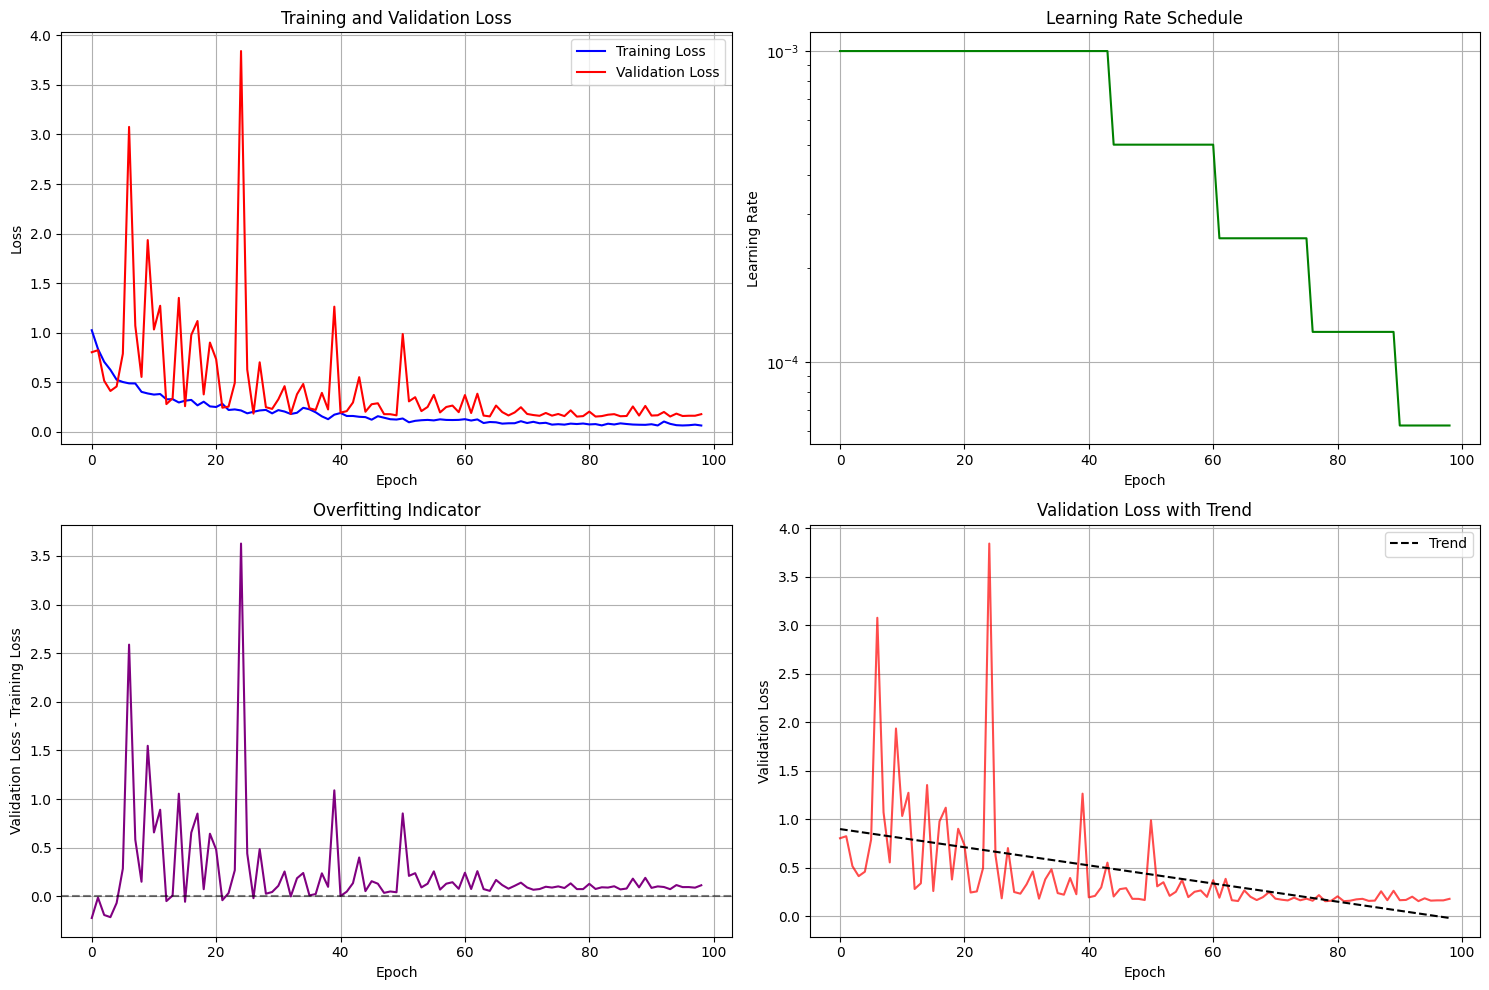

In [25]:
# Evaluate model on test set
print("\nEvaluating model on test set...")
evaluation_results = evaluate_model(
    model=trained_model,
    data_loader=test_loader,
    dataset=train_dataset,  # For normalization parameters
    fpbase_dataset=dataset,
    target_name='ex_max'
)

# Plot training history
plot_training_history(train_losses, val_losses, learning_rates)
